In [1]:
# Imports needed for the script
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Loading the data
train = pd.read_csv('/content/drive/MyDrive/Dataset/titanic_train.csv')
test = pd.read_csv('/content/drive/MyDrive/Dataset/titanic_test.csv')

# Store our test passenger IDs for easy access
PassengerId = test['PassengerId']

# Showing overview of the train dataset
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [4]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


Data description:

Survival - Survival (0 = No; 1 = Yes). Not included in test.csv file.

Pclass - Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)

Name - Name

Sex - Sex

Age - Age

Sibsp - Number of Siblings/Spouses Aboard

Parch - Number of Parents/Children Aboard

Ticket - Ticket Number

Fare - Passenger Fare

Cabin - Cabin

Embarked - Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)

In [5]:
original_train = train.copy()
original_test = test.copy()

In [6]:
full_data = [train, test]

In [7]:
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)


In [8]:
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

In [9]:
full_data

[     PassengerId  Survived  Pclass  \
 0              1         0       3   
 1              2         1       1   
 2              3         1       3   
 3              4         1       1   
 4              5         0       3   
 ..           ...       ...     ...   
 886          887         0       2   
 887          888         1       1   
 888          889         0       3   
 889          890         1       1   
 890          891         0       3   
 
                                                   Name     Sex   Age  SibSp  \
 0                              Braund, Mr. Owen Harris    male  22.0      1   
 1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
 2                               Heikkinen, Miss. Laina  female  26.0      0   
 3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
 4                             Allen, Mr. William Henry    male  35.0      0   
 ..                                               

In [10]:
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

In [11]:
full_data


[     PassengerId  Survived  Pclass  \
 0              1         0       3   
 1              2         1       1   
 2              3         1       3   
 3              4         1       1   
 4              5         0       3   
 ..           ...       ...     ...   
 886          887         0       2   
 887          888         1       1   
 888          889         0       3   
 889          890         1       1   
 890          891         0       3   
 
                                                   Name     Sex   Age  SibSp  \
 0                              Braund, Mr. Owen Harris    male  22.0      1   
 1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
 2                               Heikkinen, Miss. Laina  female  26.0      0   
 3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
 4                             Allen, Mr. William Henry    male  35.0      0   
 ..                                               

In [12]:
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')

In [13]:
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())

In [14]:
# Remove all NULLS in the Age column
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    # Next line has been improved to avoid warning
    dataset.loc[np.isnan(dataset['Age']), 'Age'] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)

In [15]:
# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return

In [16]:
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)

In [17]:
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

In [18]:
full_data

[     PassengerId  Survived  Pclass  \
 0              1         0       3   
 1              2         1       1   
 2              3         1       3   
 3              4         1       1   
 4              5         0       3   
 ..           ...       ...     ...   
 886          887         0       2   
 887          888         1       1   
 888          889         0       3   
 889          890         1       1   
 890          891         0       3   
 
                                                   Name     Sex  Age  SibSp  \
 0                              Braund, Mr. Owen Harris    male   22      1   
 1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female   38      1   
 2                               Heikkinen, Miss. Laina  female   26      0   
 3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female   35      1   
 4                             Allen, Mr. William Henry    male   35      0   
 ..                                                 ... 

In [19]:
for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)


In [20]:
full_data

[     PassengerId  Survived  Pclass  \
 0              1         0       3   
 1              2         1       1   
 2              3         1       3   
 3              4         1       1   
 4              5         0       3   
 ..           ...       ...     ...   
 886          887         0       2   
 887          888         1       1   
 888          889         0       3   
 889          890         1       1   
 890          891         0       3   
 
                                                   Name  Sex  Age  SibSp  \
 0                              Braund, Mr. Owen Harris    1   22      1   
 1    Cumings, Mrs. John Bradley (Florence Briggs Th...    0   38      1   
 2                               Heikkinen, Miss. Laina    0   26      0   
 3         Futrelle, Mrs. Jacques Heath (Lily May Peel)    0   35      1   
 4                             Allen, Mr. William Henry    1   35      0   
 ..                                                 ...  ...  ...    ...  

In [21]:
for dataset in full_data:
  # Mapping titles
    title_mapping = {"Mr": 1, "Master": 2, "Mrs": 3, "Miss": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
  # Mapping titles
    title_mapping = {"Mr": 1, "Master": 2, "Mrs": 3, "Miss": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

In [22]:
full_data

[     PassengerId  Survived  Pclass  \
 0              1         0       3   
 1              2         1       1   
 2              3         1       3   
 3              4         1       1   
 4              5         0       3   
 ..           ...       ...     ...   
 886          887         0       2   
 887          888         1       1   
 888          889         0       3   
 889          890         1       1   
 890          891         0       3   
 
                                                   Name  Sex  Age  SibSp  \
 0                              Braund, Mr. Owen Harris    1   22      1   
 1    Cumings, Mrs. John Bradley (Florence Briggs Th...    0   38      1   
 2                               Heikkinen, Miss. Laina    0   26      0   
 3         Futrelle, Mrs. Jacques Heath (Lily May Peel)    0   35      1   
 4                             Allen, Mr. William Henry    1   35      0   
 ..                                                 ...  ...  ...    ...  

In [23]:
# Feature selection: remove variables no longer containing relevant information
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
test  = test.drop(drop_elements, axis = 1)

In [24]:
train

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,22,0,7.2500,S,0,2,0,0.0
1,1,1,0,38,0,71.2833,C,1,2,0,0.0
2,1,3,0,26,0,7.9250,S,0,1,1,0.0
3,1,1,0,35,0,53.1000,S,1,2,0,0.0
4,0,3,1,35,0,8.0500,S,0,1,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,1,27,0,13.0000,S,0,1,1,0.0
887,1,1,0,19,0,30.0000,S,1,1,1,0.0
888,0,3,0,23,2,23.4500,S,0,4,0,0.0
889,1,1,1,26,0,30.0000,C,1,1,1,0.0


In [25]:
test

,Pclass,Sex,Age,Parch,Fare,Embarked,Has_Cabin,FamilySize,IsAlone,Title
0,3,1,34,0,7.8292,Q,0,1,1,0.0
1,3,0,47,0,7.0000,S,0,2,0,0.0
2,2,1,62,0,9.6875,Q,0,1,1,0.0
3,3,1,27,0,8.6625,S,0,1,1,0.0
4,3,0,22,1,12.2875,S,0,3,0,0.0
...,...,...,...,...,...,...,...,...,...,...
413,3,1,29,0,8.0500,S,0,1,1,0.0
414,1,0,39,0,108.9000,C,1,1,1,0.0
415,3,1,38,0,7.2500,S,0,1,1,0.0
416,3,1,41,0,8.0500,S,0,1,1,0.0


<Axes: title={'center': 'Pearson Correlation of Features'}>

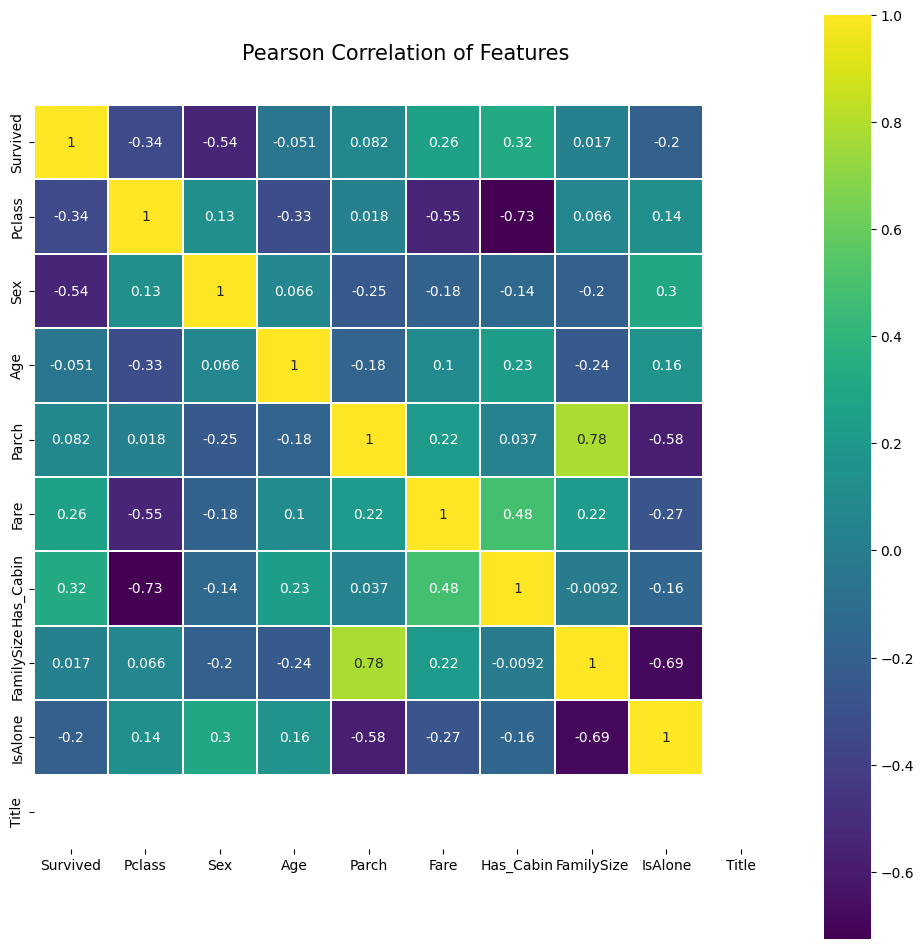

In [27]:
numerical_features = train.select_dtypes(include=np.number)
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(numerical_features.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

In [30]:
train[['Sex', 'Survived']].groupby(['Sex'], as_index=False).agg(['mean', 'count', 'sum'])

Sex  Survived           
           mean count  sum
0   0  0.742038   314  233
1   1  0.188908   577  109

In [31]:
train[['Title', 'Survived']].groupby(['Title'], as_index=False).agg(['mean', 'count', 'sum'])

Title  Survived           
             mean count  sum
0   0.0  0.383838   891  342

In [32]:
title_and_sex = original_train.copy()[['Name', 'Sex']]


In [33]:
title_and_sex

,Name,Sex
0,"Braund, Mr. Owen Harris",male
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female
2,"Heikkinen, Miss. Laina",female
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female
4,"Allen, Mr. William Henry",male
...,...,...
886,"Montvila, Rev. Juozas",male
887,"Graham, Miss. Margaret Edith",female
888,"Johnston, Miss. Catherine Helen ""Carrie""",female
889,"Behr, Mr. Karl Howell",male


In [34]:
title_and_sex['Title'] = title_and_sex['Name'].apply(get_title)

In [35]:
title_and_sex

,Name,Sex,Title
0,"Braund, Mr. Owen Harris",male,Mr
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,Mrs
2,"Heikkinen, Miss. Laina",female,Miss
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,Mrs
4,"Allen, Mr. William Henry",male,Mr
...,...,...,...
886,"Montvila, Rev. Juozas",male,Rev
887,"Graham, Miss. Margaret Edith",female,Miss
888,"Johnston, Miss. Catherine Helen ""Carrie""",female,Miss
889,"Behr, Mr. Karl Howell",male,Mr


In [36]:
title_and_sex['Sex'] = title_and_sex['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
title_and_sex[['Title', 'Sex']].groupby(['Title'], as_index=False).agg(['mean', 'count', 'sum'])

Title       Sex           
                  mean count  sum
0       Capt  1.000000     1    1
1        Col  1.000000     2    2
2   Countess  0.000000     1    0
3        Don  1.000000     1    1
4         Dr  0.857143     7    6
5   Jonkheer  1.000000     1    1
6       Lady  0.000000     1    0
7      Major  1.000000     2    2
8     Master  1.000000    40   40
9       Miss  0.000000   182    0
10      Mlle  0.000000     2    0
11       Mme  0.000000     1    0
12        Mr  1.000000   517  517
13       Mrs  0.000000   125    0
14        Ms  0.000000     1    0
15       Rev  1.000000     6    6
16       Sir  1.000000     1    1

# Gini Impurity


Gini Impurity measures the disorder of a set of elements. It is calculated as the probability of mislabelling an element assuming that the element is randomly labelled according the the distribution of all the classes in the set. Decision Trees will try to find the split which decreases Gini Impurity the most across the two resulting nodes. For the titanic example it can be calculated as follows (code should be explicit enough):

The goal of their learning algorithms is always to find the best split for each node of the tree. But measuring the "goodness" of a given split is a subjective question so, in practice, different metrics are used for evaluating splits. One commonly used metric is Information Gain. The sklearn library we're gonna use implements Gini Impurity, another common measure, so let’s explain it.

In [40]:
# Define function to calculate Gini Impurity
def get_gini_impurity(survived_count, total_count):
    survival_prob = survived_count/total_count
    not_survival_prob = (1 - survival_prob)
    random_observation_survived_prob = survival_prob
    random_observation_not_survived_prob = (1 - random_observation_survived_prob)
    mislabelling_survided_prob = not_survival_prob * random_observation_survived_prob
    mislabelling_not_survided_prob = survival_prob * random_observation_not_survived_prob
    gini_impurity = mislabelling_survided_prob + mislabelling_not_survided_prob
    return gini_impurity



In [41]:
# Gini Impurity of starting node
gini_impurity_starting_node = get_gini_impurity(342, 891)
gini_impurity_starting_node

0.47301295786144265

In [42]:
# Gini Impurity decrease of node for 'male' observations
gini_impurity_men = get_gini_impurity(109, 577)
gini_impurity_men


0.3064437162277843

In [43]:
# Gini Impurity decrease if node splited for 'female' observations
gini_impurity_women = get_gini_impurity(233, 314)
gini_impurity_women

0.3828350034484158

In [44]:
# Gini Impurity decrease if node splited by Sex
men_weight = 577/891
women_weight = 314/891
weighted_gini_impurity_sex_split = (gini_impurity_men * men_weight) + (gini_impurity_women * women_weight)

sex_gini_decrease = weighted_gini_impurity_sex_split - gini_impurity_starting_node
sex_gini_decrease

-0.13964795747285214

We're now going to simulate both splits, calculate the impurity of resulting nodes and then obtain the weighted Gini Impurity after the split to measure how much each split has actually reduced impurity.

If we split by Sex, we'll have the two following nodes:

Node with men: 577 observations with only 109 survived
Node with women: 314 observations with 233 survived


If we split by Title == 1 (== Mr), we'll have the two following nodes:

Node with only Mr: 517 observations with only 81 survived
Node with other titles: 374 observations with 261 survived


In [46]:
# Gini Impurity decrease of node for observations with Title == 1 == Mr
gini_impurity_title_1 = get_gini_impurity(81, 517)
gini_impurity_title_1
# Gini Impurity decrease if node splited for observations with Title != 1 != Mr
gini_impurity_title_others = get_gini_impurity(261, 374)
gini_impurity_title_others

0.42170207898424317

In [47]:
# Gini Impurity decrease if node splited for observations with Title == 1 == Mr
title_1_weight = 517/891
title_others_weight = 374/891
weighted_gini_impurity_title_split = (gini_impurity_title_1 * title_1_weight) + (gini_impurity_title_others * title_others_weight)

title_gini_decrease = weighted_gini_impurity_title_split - gini_impurity_starting_node
title_gini_decrease

-0.14267004758907514

# Finding best tree depth with the help of Cross Validation


In [53]:
cv = KFold(n_splits=10)            # Desired number of Cross Validation folds
accuracies = list()
max_attributes = len(list(test))
depth_range = range(1, max_attributes + 1)

# Testing max_depths from 1 to max attributes
# Uncomment prints for details about each Cross Validation pass
for depth in depth_range:
    fold_accuracy = []
    tree_model = tree.DecisionTreeClassifier(max_depth = depth)
    # print("Current max depth: ", depth, "\n")
    for train_fold, valid_fold in cv.split(train):
        f_train = train.loc[train_fold] # Extract train data with cv indices
        f_valid = train.loc[valid_fold] # Extract valid data with cv indices

        model = tree_model.fit(X = f_train.drop(['Survived'], axis=1),
                               y = f_train["Survived"]) # We fit the model with the fold train data
        valid_acc = model.score(X = f_valid.drop(['Survived'], axis=1),
                                y = f_valid["Survived"])# We calculate accuracy with the fold validation data
        fold_accuracy.append(valid_acc)

    avg = sum(fold_accuracy)/len(fold_accuracy)
    accuracies.append(avg)
    # print("Accuracy per fold: ", fold_accuracy, "\n")
    # print("Average accuracy: ", avg)
    # print("\n")

# Just to show results conveniently
df = pd.DataFrame({"Max Depth": depth_range, "Average Accuracy": accuracies})
df = df[["Max Depth", "Average Accuracy"]]
print(df.to_string(index=False))


ValueError: could not convert string to float: 'S'